<h2> Stat504 HW 3 </h2>
<h3> Part 2 </h3><br>
<b> University of Idhao </b><br>
<b> Fall 2015 </b> <br>
<b> Chung Yan Wan </b> <br>
<br> <br>
Data Set #2:  reviews_Musical_Instruments. The response variables is the reviewer’s rating in "overall": 5.0 versus 1.0 (ignore the other in-between ratings of 4.0, 3.0, and 2.0)
<br> 
Data Set #2 source: www.webpages.uidaho.edu/~stevel/504/reviews_Musical_Instruments.json
<br><br>
The common goal for both data sets is to successfully develop a model to predict the response variable given the other explanatory variables/features. Conduct a data analysis for the above Data Sets using all you have learned in the semester to cleanup, build, and  compare/contrast the performance (10-CV with AUC- measure) of various models (including variables/features selections, Null, 1) NB, 2) knn, 3) logistic regression, 4) SVM Polynomial kernel, 5) SVM Gaussian kernel, 6) Tree, 7) Bagging, 8) Random Forest, 9) Noisy Replications Ensembling, 10) plus one feasible model of your choice which was not covered in class). Overlay all model ROC curves in one figure for the same data set, with a legend key. Discuss your modeling process, interesting findings, and conclusions.

<b> Import and clean up the data

In [26]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold
import json
from pprint import pprint
import StringIO
from IPython.display import Image
from sklearn.feature_extraction.text import CountVectorizer
#this module cannot be imported on a Mac, so model 8 Voting Classifier can only be reproduced on Windows or Linux
from sklearn.ensemble import VotingClassifier
import urllib
from sklearn.naive_bayes import BernoulliNB
from astropy.table import Table, Column

In [3]:
#urllib.urlretrieve('http://www.webpages.uidaho.edu/erichs/music.json', 'C:\Users\Joanne Wan\Desktop\hw3\music.json')
with open('C:\Users\Joanne Wan\Desktop\hw3\music.json', 'rU') as f:
    data = [json.loads(row) for row in f]
    dataset2 = pd.DataFrame(data)
#we only consider onservations that their overall rating = 1 and 5
music_best_worst = dataset2[(dataset2.overall==1) | (dataset2.overall==5)]

In [4]:
print music_best_worst.shape
music_best_worst.head()

(131960, 9)


,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
1,0014072149,"[0, 0]",5,If you are a serious violin student on a budge...,"06 6, 2013",A3TS466QBAWB9D,Silver Pencil,"Perform it with a friend, today!",1370476800
2,0041291905,"[0, 0]",5,This is and excellent edition and perfectly tr...,"10 14, 2013",A3BUDYITWUSIS7,joyce gabriel cornett,Vivalldi's Four Seasons,1381708800
3,0041913574,"[0, 0]",5,Perfect for someone who is an opera fan or a w...,"09 23, 2010",A19K10Z0D2NTZK,TexasCowboy,Full score: voice and orchestra,1285200000
4,0201891859,"[0, 1]",1,How many Nocturnes does it contain? All of the...,"10 17, 2012",A14X336IB4JD89,dfjm53,Unable to determine contents,1350432000
5,0577088726,"[0, 0]",5,"this was written for Carin Levine in 2008, but...","06 14, 2013",A2HR0IL3TC4CKL,"scarecrow ""scarecrow""",arduous indeed!,1371168000


<b> set up subsets X and y, and convert all values in y to binary</b>

In [5]:
#feat_cols = ["helpful","reviewText","reviewTime","summary","unixReviewTime"] 
X = music_best_worst.reviewText
y_original = music_best_worst.overall.astype(int)
y = np.where(y_original==5, 1, 0)
print X.shape
print y.shape
print X[0:10]
print y[0:10]

(131960L,)
(131960L,)
1     If you are a serious violin student on a budge...
2     This is and excellent edition and perfectly tr...
3     Perfect for someone who is an opera fan or a w...
4     How many Nocturnes does it contain? All of the...
5     this was written for Carin Levine in 2008, but...
8     I was looking for a concert, not instructions ...
9     If you are an unabashed EC fan (as I am), you ...
12    Unless you are someone who dosen't have a clue...
13    I've played guitar for over 40 years, but it's...
16    THIS IS NOT A CLAPTON CONCERT!!! IT'S AN INSTR...
Name: reviewText, dtype: object
[1 1 1 0 1 0 1 1 1 0]


<b> Split X and y into training and testing sets</b>

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234567)
#use only the first 100 features
vect = CountVectorizer(max_features=100)

<b> Use CountVectorizer to create document-term matrices from X_train and X_test </b>

In [7]:
train_dtm = vect.fit_transform(X_train)
test_dtm = vect.transform(X_test)
dtm = vect.transform(X)

<h3>Null Model</h3>

In [60]:
#null model and its accuracy
overall_5 = np.count_nonzero(y)
print overall_5
# total observation is 131960, and overall_5=119739, so the null model is all one's. 
ypred = np.ones(131960)
null_score = 119739.0/131960.0
print ('Null model accuracy: %f' %null_score)
null_auc = metrics.roc_auc_score(y, ypred)
print ('Null model AUC: %f' %null_auc)

119739
Null model accuracy: 0.907389
Null model AUC: 0.500000


<h3>Model 1: Bernoulli Naive Bayes</h3>

<b> Find the average accuracy and AUC with 10-fold cross-validation for this model </b>

In [74]:
# 10-fold cross-validation for GaussianNB 
start = time.time()
bnb = BernoulliNB()
bnb_scores = cross_val_score(bnb, dtm, y, cv=10, scoring='accuracy')
# use average accuracy as an estimate of out-of-sample accuracy
print ("Bernoulli NB average accracy: %f" %bnb_scores.mean())
bnb_auc = cross_val_score(bnb, dtm, y, cv=10, scoring='roc_auc')
print ("Bernoulli NB AUC: %f" %bnb_auc.mean())
end = time.time()
bnb_time = end - start 
print ("Computational time (in second): %f"
      % bnb_time)

Bernoulli NB average accracy: 0.887330
Bernoulli NB AUC: 0.833571
Computational time (in second): 3.493272


<h3>Model 2: K Nearest Neighbors </h3>

<b> Find the average accuracy and AUC with 10-fold cross-validation for this model </b><br>
note: this model has not been computed, becuase it cuased memory error on my computer

In [ ]:
# 10-fold cross-validation for KNN 
start = time.time()
knn = KNeighborsClassifier()
knn_scores = cross_val_score(knn, dtm, y, cv=10, scoring='accuracy')
# use average accuracy as an estimate of out-of-sample accuracy
print ("Knn average accuracy: %f" %knn_scores.mean())
knn_auc = cross_val_score(knn, X_dtm, y, cv=10, scoring='roc_auc')
print ("knn AUC: %f" %knn_auc.mean())
end = time.time()
knn_time = end - start 
print ("Computational time (in second): %f"
      % knn_time)

<h3> Model 3: Logistcl Regression </h3>
<b> Find the average accuracy and AUC with 10-fold cross-validation for this model </b><br>

In [24]:
#10-fold cross-validation for logreg
start = time.time()
logreg = LogisticRegression(C=1e9)
logreg_scores = cross_val_score(logreg, dtm, y, cv=10, scoring='accuracy')
# use average accuracy as an estimate of out-of-sample accuracy
print ("Logistic regression average score: %f" %logreg_scores.mean())
logreg_auc = cross_val_score(logreg, dtm, y, cv=10, scoring='roc_auc')
print ("Logistic regression average AUC: %f" %logreg_auc.mean())
end = time.time()
logreg_time = end - start 
print ("Computational time (in second): %f" % logreg_time)

Logistic regression average score: 0.919188
Logistic regression average AUC: 0.872948
Computational time (in second): 36.177000


<h3> Model 4: SVM Polynomial kernel </h3>

<b> Find the average accuracy and AUC with 10-fold cross-validation for this model </b><br>
note: the SVM take an extremely long time to compute, so I dont have the results of them

In [ ]:
#10-fold cross-validation for SVM poly
start = time.time()
svm_poly = svm.SVC(kernel='poly')
svm1_scores = cross_val_score(svm_poly, dtm, y, cv=10, scoring='accuracy')
# use average accuracy as an estimate of out-of-sample accuracy
print ("SVM Polynomial average score: %f" %svm1_scores.mean())
svm1_auc = cross_val_score(svm_poly, dtm, y, cv=10, scoring='roc_auc')
print ("SVM Polynomial average AUC: %f" %svm1_auc.mean())
end = time.time()
svm1_time = end - start 
print ("Computational time (in second): %f" % svm1_time)

<h3> Model 5: SVM Gaussian kernel </h3>

<b> Find the average accuracy and AUC with 10-fold cross-validation for this model </b>

In [ ]:
#10-fold cross-validation for SVM Gaussian
start = time.time()
svm_rbf = svm.SVC(kernel='rbf')
svm2_scores = cross_val_score(svm_rbf, dtm, y, cv=10, scoring='accuracy')
# use average accuracy as an estimate of out-of-sample accuracy
print ("SVM Gaussian average score: %f" %svm2_scores.mean())
svm2_auc = cross_val_score(svm_rbf, dtm, y, cv=10, scoring='roc_auc')
print ("SVM Gaussian average score: %f" %svm2_auc.mean())
end = time.time()
svm2_time = end - start 
print ("Computational time (in second): %f" % svm2_time)

<h3> Model 6: Decision Tree Classifier </h3>

In [14]:
#decision cannot be compute, it caused memory error only computer 
# 10-fold cross-validation for Decision Tree 
start = time.time()
treeclf = DecisionTreeClassifier()
treeclf_scores = cross_val_score(treeclf, dtm, y, cv=10, scoring='accuracy').mean()
# use average accuracy as an estimate of out-of-sample accuracy
print ("Decision Tree average scores: %f" % treeclf_scores.mean())
treeclf_auc = cross_val_score(treeclf, dtm, y, cv=10, scoring='roc_auc')
print ("Decision Tree AUC: %f" % treeclf_auc.mean())
end = time.time()
treeclf_time = end - start
print ("Computational time (in second): %f"
      % treeclf_time)

Decision Tree average scores: 0.861360
Decision Tree AUC: 0.620443
Computational time (in second): 605.914000


<h3> Model 7: Ensemble Bagging </h3>

<b> Find the average accuracy and AUC with 10-fold cross-validation for this model </b>

In [79]:
# 10-fold cross-validation for Bagging
start = time.time()
bag = BaggingClassifier(n_estimators=33, max_samples=9, max_features=1.0)
bag_scores = cross_val_score(bag, dtm, y, cv=10, scoring='accuracy').mean()
# use average accuracy as an estimate of out-of-sample accuracy
print ("Bagging average scores: %f" % bag_scores.mean())
bag_auc = cross_val_score(bag, dtm, y, cv=10, scoring='roc_auc')
print ("Bagging AUC: %f" % bag_auc.mean())
end = time.time()
bag_time = end - start
print ("Computational time (in second): %f"
      % bag_time)

Bagging average scores: 0.907298
Bagging AUC: 0.585169
Computational time (in second): 85.335378


<h3> Model 8: Ensemble Random Forest </h3>

<b> Find the average accuracy and AUC with 10-fold cross-validation for this model </b>

In [81]:
# 10-fold cross-validation for Random Forest Classifier 
start = time.time()
rfc = RandomForestClassifier(n_estimators=12, max_depth=7)
rfc_scores = cross_val_score(rfc, dtm, y, cv=10, scoring='accuracy').mean()
# use average accuracy as an estimate of out-of-sample accuracy
print ("Rondom Forest Classifier average scores: %f" % rfc_scores.mean())
rfc_auc = cross_val_score(rfc, dtm, y, cv=10, scoring='roc_auc')
print ("Rondom Forest Classifier AUC: %f" % rfc_auc.mean())
end = time.time()
rfc_time = end - start
print ("Computational time (in second): %f"
      % rfc_time)

Rondom Forest Classifier average scores: 0.907396
Rondom Forest Classifier AUC: 0.832019
Computational time (in second): 54.474295


<h3> Model 9: Voting Classifier </h3>
<b> Find the average accuracy and AUC with 10-fold cross-validation for this model </b>    

In [18]:
# 10-fold cross-validation for Voting Classifier 
start = time.time()
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = BernoulliNB()
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('bnb', clf3)], voting='soft')
vc_scores = cross_val_score(eclf, dtm, y, cv=10, scoring='accuracy').mean()
# use average accuracy as an estimate of out-of-sample accuracy
print ("Voting Classifier average scores: %f" % vc_scores.mean())
vc_auc = cross_val_score(eclf, dtm, y, cv=10, scoring='roc_auc')
print ("Voting Classifier AUC: %f" % vc_auc.mean())
end = time.time()
vc_time = end - start
print ("Computational time (in second): %f"
      % vc_time)

Voting Classifier average scores: 0.917604
Voting Classifier AUC: 0.866488
Computational time (in second): 704.763000


<h3>AUC, Computation Time, and ROC </h3>

In [8]:
start1 = time.time()
bnb = BernoulliNB()
bnb.fit(train_dtm,y_train)
bnb_y_pred_prob = bnb.predict_proba(test_dtm)[:, 1]
bnb_fpr, bnb_tpr, bnb_thresholds = metrics.roc_curve(y_test, bnb_y_pred_prob)
print 'Bernoulli Naive Bayes AUC: ', metrics.roc_auc_score(y_test, bnb_y_pred_prob)
end1 = time.time()
run1 = end1 - start1
print ("Computational time: %f" %run1 )

Bernoulli Naive Bayes AUC:  0.836333816563
Computational time: 0.109000


In [9]:
start2 = time.time()
logreg = LogisticRegression(C=1e9)
logreg.fit(train_dtm,y_train)
lr_y_pred_prob = logreg.predict_proba(test_dtm)[:, 1]
lr_fpr, lr_tpr, lr_thresholds = metrics.roc_curve(y_test, lr_y_pred_prob)
print 'Logistic Regression AUC: ', metrics.roc_auc_score(y_test, lr_y_pred_prob)
end2 = time.time()
print ('Computational time: %f' %(end2-start2))

Logistic Regression AUC:  0.875620561047
Computational time: 1.619000


In [ ]:
#decision cannot be compute, it caused memory error only computer 
start3 = time.time()
knn = KNeighborsClassifier()
knn.fit(train_dtm,y_train)
knn_y_pred_prob = knn.predict_proba(test_dtm)[:, 1]
knn_fpr, knn_tpr, knn_thresholds = metrics.roc_curve(y_test, knn_y_pred_prob)
print 'Knn AUC: ', metrics.roc_auc_score(y_test, knn_y_pred_prob)
end3 = time.time()
print ('Computational time: %f' %(end3-start3))

In [12]:
start4 = time.time()
svm_poly = svm.SVC(kernel='poly',probability=True)
svm_poly.fit(train_dtm,y_train)
svm1_y_pred_prob = svm_poly.predict_proba(test_dtm)[:, 1]
svm1_fpr, svm1_tpr, svm1_thresholds = metrics.roc_curve(y_test, svm1_y_pred_prob)
print 'SVM Polynomial Kernal AUC: ', metrics.roc_auc_score(y_test, svm1_y_pred_prob)
end4 = time.time()
print ('Computational time: %f' %(end4-start4))

SVM Polynomial Kernal AUC:  0.818585486652
Computational time: 22424.309000


In [13]:
start5 = time.time()
svm_rbf = svm.SVC(kernel='rbf',probability=True)
svm_rbf.fit(train_dtm,y_train)
svm2_y_pred_prob = svm_rbf.predict_proba(test_dtm)[:, 1]
svm2_fpr, svm2_tpr, svm2_thresholds = metrics.roc_curve(y_test, svm2_y_pred_prob)
print 'SVM Gaussian Kernel AUC: ', metrics.roc_auc_score(y_test, svm2_y_pred_prob)
end5 = time.time()
print ('Computational time: %f' %(end5-start5))

SVM Gaussian Kernel AUC:  0.875295054109
Computational time: 7130.943000


In [14]:
start6 = time.time()
treeclf = DecisionTreeClassifier(max_depth = 6)
treeclf.fit(train_dtm,y_train)
ct_y_pred_prob = treeclf.predict_proba(test_dtm)[:, 1]
ct_fpr, ct_tpr, ct_thresholds = metrics.roc_curve(y_test, ct_y_pred_prob)
print 'Decision Tree AUC: ', metrics.roc_auc_score(y_test, ct_y_pred_prob)
end6 = time.time()
print ('Computational time: %f' %(end6-start6))

Decision Tree AUC:  0.77765994915
Computational time: 0.954000


In [15]:
start7 = time.time()
bag = BaggingClassifier(n_estimators=33, max_samples=9, max_features=1.0)
bag.fit(train_dtm,y_train)
bag_y_pred_prob = bag.predict_proba(test_dtm)[:, 1]
bag_fpr, bag_tpr, bag_thresholds = metrics.roc_curve(y_test, bag_y_pred_prob)
print 'Bagging AUC: ', metrics.roc_auc_score(y_test, bag_y_pred_prob)
end7 = time.time()
print ('Computational time: %f' %(end7-start7))

Bagging AUC:  0.57525560324
Computational time: 3.391000


In [16]:
start8 = time.time()
rfc = RandomForestClassifier(n_estimators=12, max_depth=7)
rfc.fit(train_dtm,y_train)
rf_y_pred_prob = rfc.predict_proba(test_dtm)[:, 1]
rf_fpr, rf_tpr, rf_thresholds = metrics.roc_curve(y_test, rf_y_pred_prob)
print 'Random Forest AUC: ', metrics.roc_auc_score(y_test, rf_y_pred_prob)
end8 = time.time()
print ('Computational time: %f' %(end8-start8))

Random Forest AUC:  0.832787577028
Computational time: 1.672000


In [18]:
start9 = time.time()
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = BernoulliNB()
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')
eclf.fit(train_dtm,y_train)
vc_y_pred_prob = eclf.predict_proba(test_dtm)[:, 1]
vc_fpr, vc_tpr, vc_thresholds = metrics.roc_curve(y_test, vc_y_pred_prob)
print 'Voting Classifier AUC: ', metrics.roc_auc_score(y_test, vc_y_pred_prob)
end9 = time.time()
print 'Computational time: %f' %(end9-start9)

Voting Classifier AUC:  0.86846657836
Computational time: 26.034000


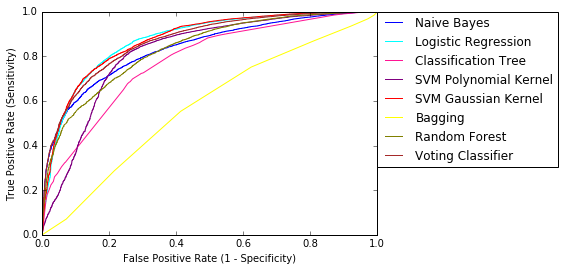

In [23]:
%matplotlib inline
plt.plot(bnb_fpr, bnb_tpr, 'blue', label ='Naive Bayes')
plt.plot(lr_fpr, lr_tpr, 'cyan', label ='Logistic Regression')
#plt.plot(knn_fpr, knn_tpr, 'black', label ='k-Nearest Neighbors')
plt.plot(ct_fpr, ct_tpr, 'deeppink', label = 'Classification Tree')
plt.plot(svm1_fpr, svm1_tpr, 'purple', label ='SVM Polynomial Kernel')
plt.plot(svm2_fpr, svm2_tpr, 'red', label ='SVM Gaussian Kernel')
plt.plot(bag_fpr, bag_tpr, 'yellow', label ='Bagging')
plt.plot(rf_fpr, rf_tpr, 'olive', label ='Random Forest')
plt.plot(vc_fpr, vc_tpr, 'brown', label ='Voting Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

<b> Logistic Regression and Decision Tree seem to yeild the greatest AUC!</b><br><br>
<h3> Results Table</h3>
Note: Some of the CV Accuracy and CU AUC result were missing because they took too long to process. I also didn't get a result from the Knn model, a monery error message popped up when I ran the model. 

In [33]:
arr = np.array([['Null', 0.907389,0.5,0.5,''],
                ['Bernoulli NB', 0.887330,0.833571,0.836333816563, run1],
                ['Knn','','', '',''],
               ['Log. Reg.', 0.919188, 872947,0.875620561047, end2-start2],
                ['SVM Poly', '', '',0.818585486652, end4-start4 ],
                ['SVM Gaussian0', '', '',0.875295054109, end5-start5],
                ['Decision Tree', 0.861360, 0.620443,0.77765994915, end6-start6],
                ['Bagging', 0.907396, 0.832019,0.57525560324, end7-start7],
                ['Random Forest',0.97396, 0.832019,0.832787577028, end8-start8],
                ['Voting Classifier', 0.917604,0.866488,0.86846657836, end9-start9]])
#The values of AUC were gotten from one train-and-test model prediction
t = Table(arr, names = ('Model','CV Accuracy', 'CV AUC', 'AUC', 'Comput. time'))
print t 

      Model       CV Accuracy  CV AUC       AUC        Comput. time 
----------------- ----------- -------- -------------- --------------
             Null    0.907389      0.5            0.5               
     Bernoulli NB     0.88733 0.833571 0.836333816563 0.108999967575
              Knn                                                   
        Log. Reg.    0.919188   872947 0.875620561047  1.61899995804
         SVM Poly                      0.818585486652      22424.309
    SVM Gaussian0                      0.875295054109  7130.94300008
    Decision Tree     0.86136 0.620443  0.77765994915 0.953999996185
          Bagging    0.907396 0.832019  0.57525560324  3.39100003242
    Random Forest     0.97396 0.832019 0.832787577028  1.67199993134
Voting Classifier    0.917604 0.866488  0.86846657836  26.0339999199
